<a href="https://colab.research.google.com/github/Zarathustra616/CV-and-ML/blob/main/VGG_Diplom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Ищем видяху Tesla P100-PCIE-16GB
!cat /proc/driver/nvidia/gpus/0000:00:04.0/information

Model: 		 Tesla K80
IRQ:   		 35
GPU UUID: 	 GPU-fc64f613-402e-a95d-098f-d230bd2f7b5c
Video BIOS: 	 80.21.25.00.02
Bus Type: 	 PCI
DMA Size: 	 40 bits
DMA Mask: 	 0xffffffffff
Bus Location: 	 0000:00:04.0
Device Minor: 	 0
Blacklisted:	 No


In [ ]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo "All libraries are successfully installed!"

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-f0ufelx5
All libraries are successfully installed!


In [ ]:
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-bine_qli
  Running command git clone -q https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-bine_qli
     |████████████████████████████████| 51.0MB 59kB/s 
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-cp37-none-any.whl size=29530 sha256=ccd44baecbe4846d448973ee165dbcb95ddec06eb454b2a2b3c96954b0152d7b
  Stored in directory: /tmp/pip-ephem-wheel-cache-bl_xfp7u/wheels/d9/10/55/6fca35a4072f87d694876d56ece64db3846cf45e1da1c381fe
Successfully built ImageDataAugmentor
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/'My Drive'/colab/with_mask.zip -d /content/
!unzip /content/gdrive/'My Drive'/colab/without_mask.zip -d /content/

In [ ]:
import io
import os
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from typing import Optional, Tuple, List, Union

from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, ZeroPadding2D, GlobalMaxPooling2D

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras import initializers
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from ImageDataAugmentor.image_data_augmentor import *
from albumentations import Compose, HorizontalFlip, Rotate

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, VGG19, VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
def preprocessing_img(label: Optional[str], data: List[Image.Image], labels: List[str], path_imgs: Optional[str], size: Tuple[int, int]) -> None:
  """Подготавливает изображения для нейронной сети """  
  #Получает список всех изображений
  path_dir = os.listdir(path_imgs)
  #imagePath: Проходит по всем изображениям
  for imagePath in path_dir:
    # Загружает изображение из заданной папки
    image = load_img(path_imgs+imagePath, target_size=size)
    # Преобразует в массив numpy
    image = img_to_array(image)
    # Преобразует для подачи в нейронку VGG16  
    image = preprocess_input(image)
    #Заполняет list массивами
    data.append(image)
    labels.append(label)
  print('---Ready---> ' + label)

In [ ]:
def augmentation_imgs(p: Optional[int]=0.5):
  """Создание дополнительных изображений""" 
  return Compose([
        HorizontalFlip(),                           # HorizontalFlip: повернутых горизонтально
        Rotate(limit=(-15, 15),border_mode=0),      # Rotate: вращение на 15 градусов
  ], p=p)                                           # р: вероятность изменения изрображения

In [ ]:
path = dict(mask='/content/with_mask/',
            no_mask='/content/without_mask/',
            image='/content/j2ApoXbK30c.jpg',
            deploy='/content/gdrive/My Drive/colab/face_detector/deploy.prototxt',
            res_10='/content/gdrive/My Drive/colab/face_detector/res10_300x300_ssd_iter_140000.caffemodel')

In [ ]:
data = []
labels = []
preprocessing_img('with_mask', data, labels, path['mask'], (224, 224))
preprocessing_img('without_mask', data, labels, path['no_mask'], (224, 224))

---Ready---> with_mask
---Ready---> without_mask


In [ ]:
# Создает Тензор 
# >>> data.shape
# >>> (5000, 224, 224, 3) Попробовать больше 5к
data = np.array(data[:5000], dtype="float32")
labels = np.array(labels[:5000])

# Преобразует название в классы 0 и 1
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [ ]:
#Разбиваем на тренировку и проверку в пропорции 0.8 и 0.2
(X_train, X_test, y_train, y_test) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)
#Освобождаем память для найшей сессии
data = []

In [ ]:
# Генератор дополнительных данных
aug = ImageDataAugmentor(augment=augmentation_imgs())
# Просмотр дополнительных данных
aug_show = aug.flow(X_train, y_train, batch_size=32)
# aug_show.show_batch()

VGG16

In [ ]:
# Block 1
  x = layers.Conv2D(
      64, (3, 3), activation='relu', padding='same', name='block1_conv1')(
          img_input)
  x = layers.Conv2D(
      64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
  x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

  # Block 2
  x = layers.Conv2D(
      128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
  x = layers.Conv2D(
      128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
  x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

  # Block 3
  x = layers.Conv2D(
      256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
  x = layers.Conv2D(
      256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
  x = layers.Conv2D(
      256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
  x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

  # Block 4
  x = layers.Conv2D(
      512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
  x = layers.Conv2D(
      512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
  x = layers.Conv2D(
      512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
  x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

  # Block 5
  x = layers.Conv2D(
      512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
  x = layers.Conv2D(
      512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
  x = layers.Conv2D(
      512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
  x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

In [ ]:

def VGG_16(weights_path=None):
    """VGG16 на tensorflow"""
    model = Sequential()
    model.add(ZeroPadding2D((1, 1),input_shape=(224, 224, 3)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(GlobalMaxPooling2D())

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    #Если есть готовые веса, то можно загрузить их
    if weights_path:
        model.load_weights(weights_path)

    return model
  

In [ ]:
# Загрузка модели
model = VGG_16()
model.compile(loss='binary_crossentropy', optimizer=SGD(), metrics=['accuracy'])
model.summary()

TypeError: ignored

In [ ]:
callbaks_list_vgg16 = [
    ModelCheckpoint(            #Сохраняет лучшую модель
        'VGG_16.h5', 
        monitor='val_accuracy', 
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(           # Ускоряеет обучение
        monitor='val_accuracy', 
        patience=3, 
        verbose=1, 
        factor=0.5, 
        min_lr=0.00001
    ) 
]

In [ ]:
# Обучаем VGG16
history_vgg16 = model.fit(aug.flow(X_train, y_train, batch_size=32),
                    epochs=100,
                    verbose=1,
                    callbacks=callbaks_list_vgg16,
                    validation_data=(X_test, y_test), 
                    steps_per_epoch=X_train.shape[0] // 32,
                    validation_steps=len(X_test) // 32)

Epoch 1/100
125/125 [==============================] - 184s 1s/step - loss: 0.6906 - accuracy: 0.5540 - val_loss: 0.6842 - val_accuracy: 0.5790

Epoch 00001: val_accuracy improved from -inf to 0.57900, saving model to VGG_16.h5
Epoch 2/100
125/125 [==============================] - 122s 976ms/step - loss: 0.6837 - accuracy: 0.5804 - val_loss: 0.6811 - val_accuracy: 0.5790

Epoch 00002: val_accuracy did not improve from 0.57900
Epoch 3/100
104/125 [=======================>......] - ETA: 18s - loss: 0.6827 - accuracy: 0.5723

KeyboardInterrupt: ignored

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(history_vgg16.history['accuracy'], label='Доля верных ответов на обучающем наборе')
plt.plot(history_vgg16.history['val_accuracy'], label='Доля верных ответов на проверочном наборе')
plt.plot(history_vgg16.history['loss'], label='Loss верных ответов на обучающем наборе')  
plt.plot(history_vgg16.history['val_loss'], label='Loss верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.savefig("Plot")
plt.show()

VGG19


In [ ]:
# Block 1
  x = layers.Conv2D(
      64, (3, 3), activation='relu', padding='same', name='block1_conv1')(
          img_input)
  x = layers.Conv2D(
      64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
  x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

  # Block 2
  x = layers.Conv2D(
      128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
  x = layers.Conv2D(
      128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
  x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

  # Block 3
  x = layers.Conv2D(
      256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
  x = layers.Conv2D(
      256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
  x = layers.Conv2D(
      256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
  x = layers.Conv2D(
      256, (3, 3), activation='relu', padding='same', name='block3_conv4')(x)
  x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

  # Block 4
  x = layers.Conv2D(
      512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
  x = layers.Conv2D(
      512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
  x = layers.Conv2D(
      512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
  x = layers.Conv2D(
      512, (3, 3), activation='relu', padding='same', name='block4_conv4')(x)
  x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

  # Block 5
  x = layers.Conv2D(
      512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
  x = layers.Conv2D(
      512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
  x = layers.Conv2D(
      512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
  x = layers.Conv2D(
      512, (3, 3), activation='relu', padding='same', name='block5_conv4')(x)
  x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

In [ ]:
vgg19 = VGG19(weights="imagenet", input_tensor=Input(shape=(224, 224, 3)),  include_top=False)
vgg19.summary()
print(vgg19.output)
head_vgg19 = vgg19.output
head_vgg19 = GlobalMaxPooling2D()(head_vgg19)
head_vgg19 = Dense(64, activation="relu")(head_vgg19)
head_vgg19 = Dropout(0.5)(head_vgg19)
head_vgg19 = Dense(64, activation="relu")(head_vgg19)
head_vgg19 = Dropout(0.5)(head_vgg19)
head_vgg19 = Dense(2, activation="softmax")(head_vgg19)

model_vgg19 = Model(inputs=vgg19.input, outputs=head_vgg19)
for layer in vgg19.layers:
	layer.trainable = False


print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

model_vgg19.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
# train the head of the network

print("[INFO] training head...")
H_vgg19 = model_vgg19.fit(aug.flow(X_train, y_train, batch_size=32),
                    epochs=100,
                    verbose=1,
                    callbacks=callbaks_list,# переименовать или он будет перезаписан
                    validation_data=(X_test, y_test), 
                    steps_per_epoch=X_train.shape[0] // 32,
                    validation_steps=len(X_test) // 32)

mobilnet2

In [ ]:

INIT_LR = 1e-4
EPOCHS = 20
BS = 32
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model1 = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
	layer.trainable = False

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

model1.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
baseModel.summary()
# train the head of the network
print("[INFO] training head...")
H = model1.fit(
	aug.flow(X_train, y_train, batch_size=BS),
	steps_per_epoch=len(X_train) // BS,
	validation_data=(X_test, y_test),
	validation_steps=len(X_test) // BS,
	epochs=EPOCHS,
  callbacks=callbaks_list)

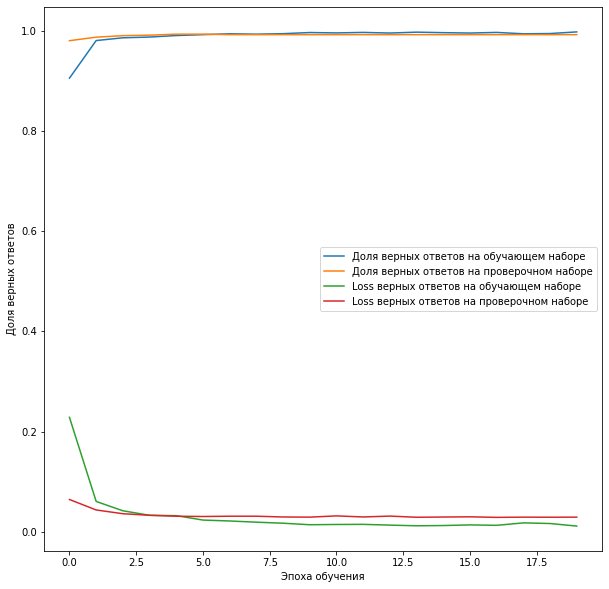

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(H.history['accuracy'], label='Доля верных ответов на обучающем наборе')
plt.plot(H.history['val_accuracy'], label='Доля верных ответов на проверочном наборе')
plt.plot(H.history['loss'], label='Loss верных ответов на обучающем наборе')  
plt.plot(H.history['val_loss'], label='Loss верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.savefig("Plot")
plt.show()  